In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3341, done.
remote: Counting objects: 100% (612/612), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 3341 (delta 531), reused 458 (delta 387), pack-reused 2729 (from 1)
Receiving objects: 100% (3341/3341), 233.19 MiB | 8.45 MiB/s, done.
Resolving deltas: 100% (2581/2581), done.
Updating files: 100% (144/144), done.


In [2]:
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e . -q
!pip install xraydb -q
!pip install xopt -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.6/105.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [3]:
!pip install scipy==1.10.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xopt 2.5.5 requires scipy>=1.10.1, but you have scipy 1.10.0 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.0 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.10.0 which is incompatible.
cvxpy 1.6.2 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which i

In [4]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import trange
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND

import torch
import gpytorch
import botorch
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator, ExpectedImprovementGenerator, TDUpperConfidenceBoundGenerator, TDExpectedImprovementGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [5]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*5e-6 - 2.5e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])



    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    result.append((do_centroid)*1e6)#my_intensity)/(61441.4336))
    del snd
  return torch.tensor(result, dtype=torch.float)

In [22]:
input = np.ones((1,8)) * 0.58
get_snd_outputs(input)

tensor([3.2590])

In [7]:
def f(input_dict: dict) -> dict:
  current_time = time.time()
  temp = current_time - start_time
  if temp > 200:
    t = current_time - start_time
  else:
    t = 0.0
  drift_mag = 0.0001
  print(f"Shift: {t*drift_mag}")
  drift_dir = np.array([1, -1, -1, 1, 1, 1, -1, -1])
  noise = np.random.rand(8) * drift_mag * 0.01
  drift_vec = drift_mag * drift_dir + noise
  drift = t * drift_vec

  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"] + drift[0], input_dict["x2"] + drift[1], input_dict["x3"] + drift[2], input_dict["x4"] + drift[3], input_dict["x5"] + drift[4], input_dict["x6"] + drift[5], input_dict["x7"] + drift[6], input_dict["x8"] + drift[7]

  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f, "time": float(current_time)}

In [8]:
def eval_function(input_dict: dict) -> dict:
  drift = 0.01
  if time > 20:
    x1, x2, x3, x4 = input_dict["x1"] + time*drift, input_dict["x2"] + time*drift, input_dict["x3"] + time*drift, input_dict["x4"] + time*drift
  else:
    x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [20]:
low =  0.0
high = 1.0
n_init = 128

vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                 "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high],
                 },
    objectives = {"f": "MINIMIZE"},
  )

evaluator = Evaluator(function=f)

generator = TDUpperConfidenceBoundGenerator(
    vocs=vocs,
    beta=0.00001,
    added_time=0.1,
    forgetting_time=50.0, #change this from 100
)
generator.n_monte_carlo_samples = 128
generator.numerical_optimizer.n_restarts = 20
generator.max_travel_distances = [4.0] * 8

start_time = time.time()
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
#X.random_evaluate(128)
sampler = qmc.LatinHypercube(d=8)
xs = sampler.random(n=n_init)
xs -= 0.5
xs /= 10
xs += 0.5

init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

for i in trange(400):
  print(f"Step: {i+1} \t Time: {time.time() - start_time}")
  X.step()
  currentstate = X.generator.data["f"][-1:]
  print(f"Current State: {currentstate}")
  time.sleep(0.1)

Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0
Shift: 0.0

  0%|          | 0/400 [00:00<?, ?it/s]

Step: 1 	 Time: 43.02979516983032
Shift: 0.0
Current State: 128    0.189346
Name: f, dtype: float64


  0%|          | 1/400 [00:04<28:25,  4.27s/it]

Step: 2 	 Time: 47.3056104183197
Shift: 0.0
Current State: 129    0.103137
Name: f, dtype: float64


  0%|          | 2/400 [00:09<31:03,  4.68s/it]

Step: 3 	 Time: 52.27449941635132
Shift: 0.0
Current State: 130    0.112062
Name: f, dtype: float64


  1%|          | 3/400 [00:14<32:14,  4.87s/it]

Step: 4 	 Time: 57.37319755554199
Shift: 0.0
Current State: 131    0.30951
Name: f, dtype: float64


  1%|          | 4/400 [00:19<33:45,  5.11s/it]

Step: 5 	 Time: 62.85637307167053
Shift: 0.0
Current State: 132    0.163905
Name: f, dtype: float64


  1%|▏         | 5/400 [00:24<31:54,  4.85s/it]

Step: 6 	 Time: 67.22929358482361
Shift: 0.0
Current State: 133    0.079333
Name: f, dtype: float64


  2%|▏         | 6/400 [00:29<32:11,  4.90s/it]

Step: 7 	 Time: 72.2384557723999
Shift: 0.0
Current State: 134    1.31131
Name: f, dtype: float64


  2%|▏         | 7/400 [00:32<28:07,  4.29s/it]

Step: 8 	 Time: 75.27964520454407
Shift: 0.0
Current State: 135    0.306491
Name: f, dtype: float64


  2%|▏         | 8/400 [00:36<27:00,  4.13s/it]

Step: 9 	 Time: 79.07309412956238
Shift: 0.0
Current State: 136    0.187825
Name: f, dtype: float64


  2%|▏         | 9/400 [00:36<20:15,  3.11s/it]

Step: 10 	 Time: 79.93041372299194
Shift: 0.0
Current State: 137    0.110277
Name: f, dtype: float64


  2%|▎         | 10/400 [00:37<16:05,  2.48s/it]

Step: 11 	 Time: 80.98389863967896
Shift: 0.0
Current State: 138    0.628506
Name: f, dtype: float64


  3%|▎         | 11/400 [00:38<12:54,  1.99s/it]

Step: 12 	 Time: 81.88151025772095
Shift: 0.0
Current State: 139    0.655005
Name: f, dtype: float64


  3%|▎         | 12/400 [00:39<11:11,  1.73s/it]

Step: 13 	 Time: 83.01418042182922
Shift: 0.0
Current State: 140    1.308151
Name: f, dtype: float64


  3%|▎         | 13/400 [00:41<10:39,  1.65s/it]

Step: 14 	 Time: 84.49246120452881
Shift: 0.0
Current State: 141    0.417551
Name: f, dtype: float64


  4%|▎         | 14/400 [00:43<10:34,  1.64s/it]

Step: 15 	 Time: 86.10999774932861
Shift: 0.0
Current State: 142    0.416619
Name: f, dtype: float64


  4%|▍         | 15/400 [00:44<09:15,  1.44s/it]

Step: 16 	 Time: 87.08383297920227
Shift: 0.0
Current State: 143    1.8573
Name: f, dtype: float64


  4%|▍         | 16/400 [00:46<11:17,  1.77s/it]

Step: 17 	 Time: 89.60156679153442
Shift: 0.0
Current State: 144    7.979259
Name: f, dtype: float64


  4%|▍         | 17/400 [00:47<09:16,  1.45s/it]

Step: 18 	 Time: 90.32854962348938
Shift: 0.0
Current State: 145    0.500105
Name: f, dtype: float64


  4%|▍         | 18/400 [00:49<10:40,  1.68s/it]

Step: 19 	 Time: 92.52641463279724
Shift: 0.0
Current State: 146    0.399543
Name: f, dtype: float64


  5%|▍         | 19/400 [00:51<11:43,  1.85s/it]

Step: 20 	 Time: 94.77110433578491
Shift: 0.0
Current State: 147    0.880813
Name: f, dtype: float64


  5%|▌         | 20/400 [00:54<13:51,  2.19s/it]

Step: 21 	 Time: 97.75284957885742
Shift: 0.0
Current State: 148    1.106076
Name: f, dtype: float64


  5%|▌         | 21/400 [00:57<14:46,  2.34s/it]

Step: 22 	 Time: 100.4423611164093
Shift: 0.0
Current State: 149    0.613945
Name: f, dtype: float64


  6%|▌         | 22/400 [00:59<15:02,  2.39s/it]

Step: 23 	 Time: 102.94640231132507
Shift: 0.0
Current State: 150    0.386603
Name: f, dtype: float64


  6%|▌         | 23/400 [01:02<14:31,  2.31s/it]

Step: 24 	 Time: 105.07855796813965
Shift: 0.0
Current State: 151    0.234565
Name: f, dtype: float64


  6%|▌         | 24/400 [01:05<16:15,  2.60s/it]

Step: 25 	 Time: 108.33719611167908
Shift: 0.0
Current State: 152    0.385339
Name: f, dtype: float64


  6%|▋         | 25/400 [01:08<17:24,  2.79s/it]

Step: 26 	 Time: 111.56764554977417
Shift: 0.0
Current State: 153    0.360557
Name: f, dtype: float64


  6%|▋         | 26/400 [01:11<17:04,  2.74s/it]

Step: 27 	 Time: 114.19353914260864
Shift: 0.0
Current State: 154    0.205211
Name: f, dtype: float64


  7%|▋         | 27/400 [01:13<15:30,  2.50s/it]

Step: 28 	 Time: 116.12466979026794
Shift: 0.0
Current State: 155    0.169519
Name: f, dtype: float64


  7%|▋         | 28/400 [01:15<14:55,  2.41s/it]

Step: 29 	 Time: 118.32945036888123
Shift: 0.0
Current State: 156    0.281899
Name: f, dtype: float64


  7%|▋         | 29/400 [01:17<15:01,  2.43s/it]

Step: 30 	 Time: 120.80512523651123
Shift: 0.0
Current State: 157    1.362666
Name: f, dtype: float64


  8%|▊         | 30/400 [01:21<16:30,  2.68s/it]

Step: 31 	 Time: 124.05662488937378
Shift: 0.0
Current State: 158    2.653361
Name: f, dtype: float64


  8%|▊         | 31/400 [01:22<14:44,  2.40s/it]

Step: 32 	 Time: 125.80531072616577
Shift: 0.0
Current State: 159    0.612983
Name: f, dtype: float64


  8%|▊         | 32/400 [01:24<14:11,  2.31s/it]

Step: 33 	 Time: 127.92191290855408
Shift: 0.0
Current State: 160    0.525424
Name: f, dtype: float64


  8%|▊         | 33/400 [01:26<12:53,  2.11s/it]

Step: 34 	 Time: 129.55365681648254
Shift: 0.0
Current State: 161    0.452225
Name: f, dtype: float64


  8%|▊         | 34/400 [01:28<12:24,  2.03s/it]

Step: 35 	 Time: 131.40913653373718
Shift: 0.0
Current State: 162    0.881535
Name: f, dtype: float64


  9%|▉         | 35/400 [01:29<11:16,  1.85s/it]

Step: 36 	 Time: 132.84857535362244
Shift: 0.0
Current State: 163    0.881831
Name: f, dtype: float64


  9%|▉         | 36/400 [01:33<13:49,  2.28s/it]

Step: 37 	 Time: 136.1179120540619
Shift: 0.0
Current State: 164    0.473003
Name: f, dtype: float64


  9%|▉         | 37/400 [01:34<12:28,  2.06s/it]

Step: 38 	 Time: 137.67360281944275
Shift: 0.0
Current State: 165    0.977143
Name: f, dtype: float64


 10%|▉         | 38/400 [01:36<12:08,  2.01s/it]

Step: 39 	 Time: 139.56681656837463
Shift: 0.0
Current State: 166    0.487436
Name: f, dtype: float64


 10%|▉         | 39/400 [01:37<10:44,  1.79s/it]

Step: 40 	 Time: 140.82729935646057
Shift: 0.0
Current State: 167    2.650421
Name: f, dtype: float64


 10%|█         | 40/400 [01:38<08:56,  1.49s/it]

Step: 41 	 Time: 141.6269781589508
Shift: 0.0
Current State: 168    14.942955
Name: f, dtype: float64


 10%|█         | 41/400 [01:39<07:27,  1.25s/it]

Step: 42 	 Time: 142.30316495895386
Shift: 0.0
Current State: 169    0.542244
Name: f, dtype: float64


 10%|█         | 42/400 [01:41<09:46,  1.64s/it]

Step: 43 	 Time: 144.86049723625183
Shift: 0.0
Current State: 170    0.634375
Name: f, dtype: float64


 11%|█         | 43/400 [01:44<12:25,  2.09s/it]

Step: 44 	 Time: 147.99247694015503
Shift: 0.0
Current State: 171    0.532767
Name: f, dtype: float64


 11%|█         | 44/400 [01:46<12:06,  2.04s/it]

Step: 45 	 Time: 149.9217827320099
Shift: 0.0
Current State: 172    0.652046
Name: f, dtype: float64


 11%|█▏        | 45/400 [01:50<14:02,  2.37s/it]

Step: 46 	 Time: 153.0753152370453
Shift: 0.0
Current State: 173    0.331096
Name: f, dtype: float64


 12%|█▏        | 46/400 [01:52<14:03,  2.38s/it]

Step: 47 	 Time: 155.4775402545929
Shift: 0.0
Current State: 174    0.396189
Name: f, dtype: float64


 12%|█▏        | 47/400 [01:54<13:18,  2.26s/it]

Step: 48 	 Time: 157.45925283432007
Shift: 0.0
Current State: 175    0.364739
Name: f, dtype: float64


 12%|█▏        | 48/400 [01:57<14:55,  2.54s/it]

Step: 49 	 Time: 160.65827250480652
Shift: 0.0
Current State: 176    0.382668
Name: f, dtype: float64


 12%|█▏        | 49/400 [01:59<13:47,  2.36s/it]

Step: 50 	 Time: 162.58512592315674
Shift: 0.0
Current State: 177    0.363018
Name: f, dtype: float64


 12%|█▎        | 50/400 [02:01<13:11,  2.26s/it]

Step: 51 	 Time: 164.61879992485046
Shift: 0.0
Current State: 178    0.251485
Name: f, dtype: float64


 13%|█▎        | 51/400 [02:03<13:21,  2.30s/it]

Step: 52 	 Time: 166.9977467060089
Shift: 0.0
Current State: 179    0.160678
Name: f, dtype: float64


 13%|█▎        | 52/400 [02:05<12:39,  2.18s/it]

Step: 53 	 Time: 168.9121196269989
Shift: 0.0
Current State: 180    0.096147
Name: f, dtype: float64


 13%|█▎        | 53/400 [02:09<14:38,  2.53s/it]

Step: 54 	 Time: 172.26302552223206
Shift: 0.0
Current State: 181    0.514031
Name: f, dtype: float64


 14%|█▎        | 54/400 [02:11<14:40,  2.55s/it]

Step: 55 	 Time: 174.83743524551392
Shift: 0.0
Current State: 182    0.742329
Name: f, dtype: float64


 14%|█▍        | 55/400 [02:14<14:14,  2.48s/it]

Step: 56 	 Time: 177.15018367767334
Shift: 0.0
Current State: 183    0.536176
Name: f, dtype: float64


 14%|█▍        | 56/400 [02:16<13:13,  2.31s/it]

Step: 57 	 Time: 179.0670347213745
Shift: 0.0
Current State: 184    0.822532
Name: f, dtype: float64


 14%|█▍        | 57/400 [02:18<13:23,  2.34s/it]

Step: 58 	 Time: 181.4938142299652
Shift: 0.0
Current State: 185    0.260994
Name: f, dtype: float64


 14%|█▍        | 58/400 [02:19<11:02,  1.94s/it]

Step: 59 	 Time: 182.48407340049744
Shift: 0.0
Current State: 186    1.154672
Name: f, dtype: float64


 15%|█▍        | 59/400 [02:20<09:54,  1.74s/it]

Step: 60 	 Time: 183.77366733551025
Shift: 0.0
Current State: 187    1.561615
Name: f, dtype: float64


 15%|█▌        | 60/400 [02:22<09:07,  1.61s/it]

Step: 61 	 Time: 185.07519364356995
Shift: 0.0
Current State: 188    3.391526
Name: f, dtype: float64


 15%|█▌        | 61/400 [02:24<10:45,  1.90s/it]

Step: 62 	 Time: 187.6628339290619
Shift: 0.0
Current State: 189    1.808292
Name: f, dtype: float64


 16%|█▌        | 62/400 [02:25<09:41,  1.72s/it]

Step: 63 	 Time: 188.9513885974884
Shift: 0.0
Current State: 190    2.244541
Name: f, dtype: float64


 16%|█▌        | 63/400 [02:26<08:21,  1.49s/it]

Step: 64 	 Time: 189.90173602104187
Shift: 0.0
Current State: 191    1.508465
Name: f, dtype: float64


 16%|█▌        | 64/400 [02:28<08:04,  1.44s/it]

Step: 65 	 Time: 191.23204898834229
Shift: 0.0
Current State: 192    0.756201
Name: f, dtype: float64


 16%|█▋        | 65/400 [02:30<08:44,  1.57s/it]

Step: 66 	 Time: 193.0905339717865
Shift: 0.0
Current State: 193    3.190456
Name: f, dtype: float64


 16%|█▋        | 66/400 [02:33<12:08,  2.18s/it]

Step: 67 	 Time: 196.7110776901245
Shift: 0.0
Current State: 194    4.067173
Name: f, dtype: float64


 17%|█▋        | 67/400 [02:34<09:57,  1.79s/it]

Step: 68 	 Time: 197.59767723083496
Shift: 0.0
Current State: 195    0.871072
Name: f, dtype: float64


 17%|█▋        | 68/400 [02:35<09:10,  1.66s/it]

Step: 69 	 Time: 198.9363453388214
Shift: 0.0
Current State: 196    0.480478
Name: f, dtype: float64


 17%|█▋        | 69/400 [02:36<07:51,  1.42s/it]

Step: 70 	 Time: 199.81315755844116
Shift: 0.020023556709289552
Current State: 197    1.089782
Name: f, dtype: float64


 18%|█▊        | 70/400 [02:37<06:49,  1.24s/it]

Step: 71 	 Time: 200.63010120391846
Shift: 0.020179365158081056
Current State: 198    0.561601
Name: f, dtype: float64


 18%|█▊        | 71/400 [02:39<07:19,  1.34s/it]

Step: 72 	 Time: 202.18608927726746
Shift: 0.02030582745075226
Current State: 199    0.841914
Name: f, dtype: float64


 18%|█▊        | 72/400 [02:40<07:12,  1.32s/it]

Step: 73 	 Time: 203.4627242088318
Shift: 0.020516183543205262
Current State: 200    0.246274
Name: f, dtype: float64


 18%|█▊        | 73/400 [02:42<08:28,  1.55s/it]

Step: 74 	 Time: 205.56766200065613
Shift: 0.02060291805267334
Current State: 201    0.120148
Name: f, dtype: float64


 18%|█▊        | 74/400 [02:43<07:19,  1.35s/it]

Step: 75 	 Time: 206.44043803215027
Shift: 0.02068812026977539
Current State: 202    0.121275
Name: f, dtype: float64


 19%|█▉        | 75/400 [02:44<06:27,  1.19s/it]

Step: 76 	 Time: 207.26967358589172
Shift: 0.02081495876312256
Current State: 203    0.139279
Name: f, dtype: float64


 19%|█▉        | 76/400 [02:45<06:52,  1.27s/it]

Step: 77 	 Time: 208.7261619567871
Shift: 0.02095131666660309
Current State: 204    0.154922
Name: f, dtype: float64


 19%|█▉        | 77/400 [02:46<06:44,  1.25s/it]

Step: 78 	 Time: 209.92670488357544
Shift: 0.02106183922290802
Current State: 205    0.189448
Name: f, dtype: float64


 20%|█▉        | 78/400 [02:47<06:27,  1.20s/it]

Step: 79 	 Time: 211.0144021511078
Shift: 0.021173908710479736
Current State: 206    0.214855
Name: f, dtype: float64


 20%|█▉        | 79/400 [02:49<06:17,  1.18s/it]

Step: 80 	 Time: 212.12930369377136
Shift: 0.021333297896385193
Current State: 207    0.163348
Name: f, dtype: float64


 20%|██        | 80/400 [02:50<06:57,  1.31s/it]

Step: 81 	 Time: 213.73862671852112
Shift: 0.021412877440452577
Current State: 208    0.423846
Name: f, dtype: float64


 20%|██        | 81/400 [02:51<06:06,  1.15s/it]

Step: 82 	 Time: 214.5247929096222
Shift: 0.02148953814506531
Current State: 209    0.34645
Name: f, dtype: float64


 20%|██        | 82/400 [02:52<05:28,  1.03s/it]

Step: 83 	 Time: 215.2891731262207
Shift: 0.021587146520614626
Current State: 210    0.282532
Name: f, dtype: float64


 21%|██        | 83/400 [02:53<05:22,  1.02s/it]

Step: 84 	 Time: 216.26979231834412
Shift: 0.021673419117927552
Current State: 211    0.152148
Name: f, dtype: float64


 21%|██        | 84/400 [02:54<05:07,  1.03it/s]

Step: 85 	 Time: 217.137615442276
Shift: 0.021754752945899965
Current State: 212    0.148843
Name: f, dtype: float64


 21%|██▏       | 85/400 [02:54<04:51,  1.08it/s]

Step: 86 	 Time: 217.9489507675171
Shift: 0.021844992113113405
Current State: 213    0.186897
Name: f, dtype: float64


 22%|██▏       | 86/400 [02:55<04:48,  1.09it/s]

Step: 87 	 Time: 218.85095357894897
Shift: 0.02192699706554413
Current State: 214    0.125185
Name: f, dtype: float64


 22%|██▏       | 87/400 [02:56<04:37,  1.13it/s]

Step: 88 	 Time: 219.66760349273682
Shift: 0.022097230315208435
Current State: 215    0.093437
Name: f, dtype: float64


 22%|██▏       | 88/400 [02:58<06:06,  1.17s/it]

Step: 89 	 Time: 221.51205110549927
Shift: 0.022226585149765016
Current State: 216    0.12128
Name: f, dtype: float64


 22%|██▏       | 89/400 [02:59<06:03,  1.17s/it]

Step: 90 	 Time: 222.6728208065033
Shift: 0.022321744537353517
Current State: 217    0.187497
Name: f, dtype: float64


 22%|██▎       | 90/400 [03:00<05:41,  1.10s/it]

Step: 91 	 Time: 223.61134243011475
Shift: 0.022405016398429872
Current State: 218    0.293228
Name: f, dtype: float64


 23%|██▎       | 91/400 [03:01<05:15,  1.02s/it]

Step: 92 	 Time: 224.4439148902893
Shift: 0.022497041893005373
Current State: 219    0.66168
Name: f, dtype: float64


 23%|██▎       | 92/400 [03:02<05:05,  1.01it/s]

Step: 93 	 Time: 225.37327766418457
Shift: 0.022679767513275148
Current State: 220    2.039188
Name: f, dtype: float64


 23%|██▎       | 93/400 [03:04<06:23,  1.25s/it]

Step: 94 	 Time: 227.21987652778625
Shift: 0.022881884717941284
Current State: 221    0.503334
Name: f, dtype: float64


 24%|██▎       | 94/400 [03:06<07:30,  1.47s/it]

Step: 95 	 Time: 229.2180986404419
Shift: 0.022987953066825866
Current State: 222    0.072646
Name: f, dtype: float64


 24%|██▍       | 95/400 [03:07<06:51,  1.35s/it]

Step: 96 	 Time: 230.2786350250244
Shift: 0.023058229207992553
Current State: 223    9.681314
Name: f, dtype: float64


 24%|██▍       | 96/400 [03:07<05:50,  1.15s/it]

Step: 97 	 Time: 230.97455716133118
Shift: 0.023167638683319093
Current State: 224    0.897686
Name: f, dtype: float64


 24%|██▍       | 97/400 [03:09<05:44,  1.14s/it]

Step: 98 	 Time: 232.07096433639526
Shift: 0.02329619734287262
Current State: 225    0.39605
Name: f, dtype: float64


 24%|██▍       | 98/400 [03:10<06:12,  1.23s/it]

Step: 99 	 Time: 233.53525185585022
Shift: 0.02358219373226166
Current State: 226    0.598202
Name: f, dtype: float64


 25%|██▍       | 99/400 [03:13<08:22,  1.67s/it]

Step: 100 	 Time: 236.21752548217773
Shift: 0.02368823890686035
Current State: 227    0.492323
Name: f, dtype: float64


 25%|██▌       | 100/400 [03:14<07:26,  1.49s/it]

Step: 101 	 Time: 237.28619074821472
Shift: 0.02399374899864197
Current State: 228    1.132687
Name: f, dtype: float64


 25%|██▌       | 101/400 [03:17<09:45,  1.96s/it]

Step: 102 	 Time: 240.3380184173584
Shift: 0.02410054340362549
Current State: 229    0.402205
Name: f, dtype: float64


 26%|██▌       | 102/400 [03:18<08:23,  1.69s/it]

Step: 103 	 Time: 241.4052243232727
Shift: 0.02419786756038666
Current State: 230    0.139785
Name: f, dtype: float64


 26%|██▌       | 103/400 [03:19<07:17,  1.47s/it]

Step: 104 	 Time: 242.37188005447388
Shift: 0.02432694230079651
Current State: 231    0.120837
Name: f, dtype: float64


 26%|██▌       | 104/400 [03:20<07:00,  1.42s/it]

Step: 105 	 Time: 243.66471815109253
Shift: 0.02443689105510712
Current State: 232    0.126754
Name: f, dtype: float64


 26%|██▋       | 105/400 [03:21<06:40,  1.36s/it]

Step: 106 	 Time: 244.87857389450073
Shift: 0.024644220232963563
Current State: 233    0.122059
Name: f, dtype: float64


 26%|██▋       | 106/400 [03:23<07:46,  1.59s/it]

Step: 107 	 Time: 246.99605298042297
Shift: 0.024750761818885806
Current State: 234    1.049393
Name: f, dtype: float64


 27%|██▋       | 107/400 [03:24<06:45,  1.38s/it]

Step: 108 	 Time: 247.9092676639557
Shift: 0.024900662231445315
Current State: 235    0.060137
Name: f, dtype: float64


 27%|██▋       | 108/400 [03:26<06:54,  1.42s/it]

Step: 109 	 Time: 249.4162974357605
Shift: 0.02503895163536072
Current State: 236    0.153408
Name: f, dtype: float64


 27%|██▋       | 109/400 [03:27<06:49,  1.41s/it]

Step: 110 	 Time: 250.79166769981384
Shift: 0.025198211646080017
Current State: 237    0.098804
Name: f, dtype: float64


 28%|██▊       | 110/400 [03:29<07:04,  1.46s/it]

Step: 111 	 Time: 252.3819580078125
Shift: 0.025290384054183962
Current State: 238    1.381455
Name: f, dtype: float64


 28%|██▊       | 111/400 [03:30<06:16,  1.30s/it]

Step: 112 	 Time: 253.31552171707153
Shift: 0.025402216625213626
Current State: 239    0.113566
Name: f, dtype: float64


 28%|██▊       | 112/400 [03:31<05:59,  1.25s/it]

Step: 113 	 Time: 254.43164801597595
Shift: 0.02582283754348755
Current State: 240    0.014278
Name: f, dtype: float64


 28%|██▊       | 113/400 [03:35<10:23,  2.17s/it]

Step: 114 	 Time: 258.7612056732178
Shift: 0.026309085512161257
Current State: 241    0.057872
Name: f, dtype: float64


 28%|██▊       | 114/400 [03:40<14:01,  2.94s/it]

Step: 115 	 Time: 263.5069115161896
Shift: 0.026480162858963013
Current State: 242    0.143353
Name: f, dtype: float64


 29%|██▉       | 115/400 [03:42<12:12,  2.57s/it]

Step: 116 	 Time: 265.20522809028625
Shift: 0.026794827580451968
Current State: 243    0.182604
Name: f, dtype: float64


 29%|██▉       | 116/400 [03:45<12:59,  2.74s/it]

Step: 117 	 Time: 268.35602045059204
Shift: 0.027217437887191775
Current State: 244    0.337549
Name: f, dtype: float64


 29%|██▉       | 117/400 [03:49<15:02,  3.19s/it]

Step: 118 	 Time: 272.5763671398163
Shift: 0.027529287981987
Current State: 245    0.149311
Name: f, dtype: float64


 30%|██▉       | 118/400 [03:52<14:53,  3.17s/it]

Step: 119 	 Time: 275.69764018058777
Shift: 0.027758781671524048
Current State: 246    3.546751
Name: f, dtype: float64


 30%|██▉       | 119/400 [03:54<13:37,  2.91s/it]

Step: 120 	 Time: 278.00878953933716
Shift: 0.027966517567634585
Current State: 247    0.80397
Name: f, dtype: float64


 30%|███       | 120/400 [03:57<12:24,  2.66s/it]

Step: 121 	 Time: 280.0808596611023
Shift: 0.028245039129257205
Current State: 248    0.798868
Name: f, dtype: float64


 30%|███       | 121/400 [03:59<12:42,  2.73s/it]

Step: 122 	 Time: 282.9867539405823
Shift: 0.028358522605895997
Current State: 249    0.842363
Name: f, dtype: float64


 30%|███       | 122/400 [04:01<10:22,  2.24s/it]

Step: 123 	 Time: 284.0771110057831
Shift: 0.02845088176727295
Current State: 250    0.847405
Name: f, dtype: float64


 31%|███       | 123/400 [04:01<08:23,  1.82s/it]

Step: 124 	 Time: 284.90916299819946
Shift: 0.028533485007286072
Current State: 251    0.840722
Name: f, dtype: float64


 31%|███       | 124/400 [04:02<06:59,  1.52s/it]

Step: 125 	 Time: 285.7330415248871
Shift: 0.028629058146476746
Current State: 252    0.830342
Name: f, dtype: float64


 31%|███▏      | 125/400 [04:03<06:12,  1.35s/it]

Step: 126 	 Time: 286.6968014240265
Shift: 0.028720755314826967
Current State: 253    0.129803
Name: f, dtype: float64


 32%|███▏      | 126/400 [04:04<05:36,  1.23s/it]

Step: 127 	 Time: 287.62856554985046
Shift: 0.028824622011184693
Current State: 254    0.113118
Name: f, dtype: float64


 32%|███▏      | 127/400 [04:05<05:18,  1.17s/it]

Step: 128 	 Time: 288.6573009490967
Shift: 0.02891545879840851
Current State: 255    9.146191
Name: f, dtype: float64


 32%|███▏      | 128/400 [04:06<04:56,  1.09s/it]

Step: 129 	 Time: 289.57145738601685
Shift: 0.029158336210250855
Current State: 256    0.236489
Name: f, dtype: float64


 32%|███▏      | 129/400 [04:08<06:42,  1.49s/it]

Step: 130 	 Time: 291.9794125556946
Shift: 0.02944925973415375
Current State: 257    0.240296
Name: f, dtype: float64


 32%|███▎      | 130/400 [04:11<08:43,  1.94s/it]

Step: 131 	 Time: 294.977578163147
Shift: 0.02980019419193268
Current State: 258    0.125978
Name: f, dtype: float64


 33%|███▎      | 131/400 [04:15<10:41,  2.39s/it]

Step: 132 	 Time: 298.4009745121002
Shift: 0.029979505920410158
Current State: 259    0.427822
Name: f, dtype: float64


 33%|███▎      | 132/400 [04:17<09:51,  2.21s/it]

Step: 133 	 Time: 300.1913871765137
Shift: 0.030187624216079713
Current State: 260    0.33452
Name: f, dtype: float64


 33%|███▎      | 133/400 [04:19<09:38,  2.17s/it]

Step: 134 	 Time: 302.2699406147003
Shift: 0.03046683123111725
Current State: 261    0.55169
Name: f, dtype: float64


 34%|███▎      | 134/400 [04:22<10:27,  2.36s/it]

Step: 135 	 Time: 305.0742585659027
Shift: 0.03078072545528412
Current State: 262    0.543912
Name: f, dtype: float64


 34%|███▍      | 135/400 [04:25<11:37,  2.63s/it]

Step: 136 	 Time: 308.33818435668945
Shift: 0.030900419473648074
Current State: 263    0.838171
Name: f, dtype: float64


 34%|███▍      | 136/400 [04:26<09:30,  2.16s/it]

Step: 137 	 Time: 309.40783858299255
Shift: 0.030991899728775026
Current State: 264    0.132861
Name: f, dtype: float64


 34%|███▍      | 137/400 [04:27<07:50,  1.79s/it]

Step: 138 	 Time: 310.32883286476135
Shift: 0.031164880299568178
Current State: 265    0.12213
Name: f, dtype: float64


 34%|███▍      | 138/400 [04:29<07:45,  1.77s/it]

Step: 139 	 Time: 312.06827449798584
Shift: 0.03138341567516327
Current State: 266    0.377011
Name: f, dtype: float64


 35%|███▍      | 139/400 [04:31<08:14,  1.89s/it]

Step: 140 	 Time: 314.2437789440155
Shift: 0.031593777465820316
Current State: 267    0.131482
Name: f, dtype: float64


 35%|███▌      | 140/400 [04:33<08:28,  1.96s/it]

Step: 141 	 Time: 316.34434270858765
Shift: 0.03168255610466004
Current State: 268    0.913103
Name: f, dtype: float64


 35%|███▌      | 141/400 [04:34<07:03,  1.63s/it]

Step: 142 	 Time: 317.22713136672974
Shift: 0.031769767618179325
Current State: 269    0.517567
Name: f, dtype: float64


 36%|███▌      | 142/400 [04:35<06:01,  1.40s/it]

Step: 143 	 Time: 318.08965492248535
Shift: 0.03187594199180603
Current State: 270    0.072172
Name: f, dtype: float64


 36%|███▌      | 143/400 [04:36<05:36,  1.31s/it]

Step: 144 	 Time: 319.17649364471436
Shift: 0.03212266848087311
Current State: 271    0.247876
Name: f, dtype: float64


 36%|███▌      | 144/400 [04:38<07:05,  1.66s/it]

Step: 145 	 Time: 321.6664912700653
Shift: 0.032274891138076786
Current State: 272    0.252086
Name: f, dtype: float64


 36%|███▋      | 145/400 [04:40<06:49,  1.61s/it]

Step: 146 	 Time: 323.1441812515259
Shift: 0.03241806735992432
Current State: 273    0.396272
Name: f, dtype: float64


 36%|███▋      | 146/400 [04:41<06:35,  1.56s/it]

Step: 147 	 Time: 324.5785779953003
Shift: 0.03260428750514984
Current State: 274    0.06755
Name: f, dtype: float64


 37%|███▋      | 147/400 [04:43<06:56,  1.65s/it]

Step: 148 	 Time: 326.43703985214233
Shift: 0.032699429464340214
Current State: 275    0.487026
Name: f, dtype: float64


 37%|███▋      | 148/400 [04:44<06:02,  1.44s/it]

Step: 149 	 Time: 327.3874189853668
Shift: 0.03279331548213959
Current State: 276    0.453602
Name: f, dtype: float64


 37%|███▋      | 149/400 [04:45<05:23,  1.29s/it]

Step: 150 	 Time: 328.3254859447479
Shift: 0.03296972982883453
Current State: 277    1.791405
Name: f, dtype: float64


 38%|███▊      | 150/400 [04:47<05:57,  1.43s/it]

Step: 151 	 Time: 330.09153842926025
Shift: 0.03304941363334656
Current State: 278    0.357615
Name: f, dtype: float64


 38%|███▊      | 151/400 [04:47<05:11,  1.25s/it]

Step: 152 	 Time: 330.9162368774414
Shift: 0.03318191514015198
Current State: 279    0.32213
Name: f, dtype: float64


 38%|███▊      | 152/400 [04:49<05:23,  1.30s/it]

Step: 153 	 Time: 332.3477337360382
Shift: 0.033339258146286015
Current State: 280    0.181707
Name: f, dtype: float64


 38%|███▊      | 153/400 [04:50<05:45,  1.40s/it]

Step: 154 	 Time: 333.96319675445557
Shift: 0.03344126465320588
Current State: 281    0.208251
Name: f, dtype: float64


 38%|███▊      | 154/400 [04:51<05:04,  1.24s/it]

Step: 155 	 Time: 334.8272213935852
Shift: 0.03364605441093445
Current State: 282    0.135382
Name: f, dtype: float64


 39%|███▉      | 155/400 [04:53<06:03,  1.48s/it]

Step: 156 	 Time: 336.88608860969543
Shift: 0.03380359959602356
Current State: 283    0.156913
Name: f, dtype: float64


 39%|███▉      | 156/400 [04:55<06:09,  1.51s/it]

Step: 157 	 Time: 338.4693820476532
Shift: 0.034063714265823365
Current State: 284    0.061333
Name: f, dtype: float64


 39%|███▉      | 157/400 [04:58<07:26,  1.84s/it]

Step: 158 	 Time: 341.06281876564026
Shift: 0.0341356066942215
Current State: 285    2.902391
Name: f, dtype: float64


 40%|███▉      | 158/400 [04:58<06:03,  1.50s/it]

Step: 159 	 Time: 341.7837772369385
Shift: 0.03422640163898468
Current State: 286    0.088027
Name: f, dtype: float64


 40%|███▉      | 159/400 [04:59<05:19,  1.33s/it]

Step: 160 	 Time: 342.7008376121521
Shift: 0.034308619856834414
Current State: 287    15.57439
Name: f, dtype: float64


 40%|████      | 160/400 [05:00<04:42,  1.18s/it]

Step: 161 	 Time: 343.5219519138336
Shift: 0.03455796937942505
Current State: 288    0.137978
Name: f, dtype: float64


 40%|████      | 161/400 [05:03<06:24,  1.61s/it]

Step: 162 	 Time: 346.13733744621277
Shift: 0.03483671426773072
Current State: 289    0.175073
Name: f, dtype: float64


 40%|████      | 162/400 [05:05<07:37,  1.92s/it]

Step: 163 	 Time: 348.79754757881165
Shift: 0.03512639901638031
Current State: 290    0.049053
Name: f, dtype: float64


 41%|████      | 163/400 [05:08<08:45,  2.22s/it]

Step: 164 	 Time: 351.70816135406494
Shift: 0.03530462522506714
Current State: 291    0.314922
Name: f, dtype: float64


 41%|████      | 164/400 [05:10<08:12,  2.09s/it]

Step: 165 	 Time: 353.4825122356415
Shift: 0.03553760805130005
Current State: 292    0.295023
Name: f, dtype: float64


 41%|████▏     | 165/400 [05:12<08:25,  2.15s/it]

Step: 166 	 Time: 355.78924536705017
Shift: 0.03573892371654511
Current State: 293    0.30553
Name: f, dtype: float64


 42%|████▏     | 166/400 [05:14<08:20,  2.14s/it]

Step: 167 	 Time: 357.9010000228882
Shift: 0.03592845761775971
Current State: 294    2.876267
Name: f, dtype: float64


 42%|████▏     | 167/400 [05:16<07:54,  2.03s/it]

Step: 168 	 Time: 359.69025206565857
Shift: 0.0361937019109726
Current State: 295    0.343396
Name: f, dtype: float64


 42%|████▏     | 168/400 [05:19<08:34,  2.22s/it]

Step: 169 	 Time: 362.34145498275757
Shift: 0.03646490120887756
Current State: 296    0.563467
Name: f, dtype: float64


 42%|████▏     | 169/400 [05:22<09:06,  2.36s/it]

Step: 170 	 Time: 365.04353976249695
Shift: 0.036718931102752685
Current State: 297    1.893163
Name: f, dtype: float64


 42%|████▎     | 170/400 [05:24<09:16,  2.42s/it]

Step: 171 	 Time: 367.5877959728241
Shift: 0.03691521248817444
Current State: 298    1.721182
Name: f, dtype: float64


 43%|████▎     | 171/400 [05:26<08:48,  2.31s/it]

Step: 172 	 Time: 369.64493346214294
Shift: 0.037190956807136535
Current State: 299    0.856574
Name: f, dtype: float64


 43%|████▎     | 172/400 [05:29<09:11,  2.42s/it]

Step: 173 	 Time: 372.31611466407776
Shift: 0.03739096276760102
Current State: 300    0.655706
Name: f, dtype: float64


 43%|████▎     | 173/400 [05:31<08:40,  2.29s/it]

Step: 174 	 Time: 374.31847190856934
Shift: 0.03766646976470948
Current State: 301    0.354477
Name: f, dtype: float64


 44%|████▎     | 174/400 [05:34<09:08,  2.43s/it]

Step: 175 	 Time: 377.0599935054779
Shift: 0.037930821204185484
Current State: 302    0.55147
Name: f, dtype: float64


 44%|████▍     | 175/400 [05:36<09:22,  2.50s/it]

Step: 176 	 Time: 379.72453355789185
Shift: 0.03824166038036347
Current State: 303    0.640748
Name: f, dtype: float64


 44%|████▍     | 176/400 [05:39<10:08,  2.72s/it]

Step: 177 	 Time: 382.95338678359985
Shift: 0.0385087785243988
Current State: 304    0.404342
Name: f, dtype: float64


 44%|████▍     | 177/400 [05:42<09:53,  2.66s/it]

Step: 178 	 Time: 385.4869349002838
Shift: 0.038756149673461915
Current State: 305    1.240262
Name: f, dtype: float64


 44%|████▍     | 178/400 [05:44<09:39,  2.61s/it]

Step: 179 	 Time: 387.9688444137573
Shift: 0.038951227021217345
Current State: 306    0.208084
Name: f, dtype: float64


 45%|████▍     | 179/400 [05:46<08:52,  2.41s/it]

Step: 180 	 Time: 389.9094076156616
Shift: 0.03914541184902191
Current State: 307    0.111662
Name: f, dtype: float64


 45%|████▌     | 180/400 [05:48<08:18,  2.27s/it]

Step: 181 	 Time: 391.8468933105469
Shift: 0.03938661530017853
Current State: 308    0.118403
Name: f, dtype: float64


 45%|████▌     | 181/400 [05:51<08:32,  2.34s/it]

Step: 182 	 Time: 394.35534286499023
Shift: 0.03948956439495087
Current State: 309    0.85223
Name: f, dtype: float64


 46%|████▌     | 182/400 [05:52<07:04,  1.95s/it]

Step: 183 	 Time: 395.396009683609
Shift: 0.039581980776786804
Current State: 310    7.740057
Name: f, dtype: float64


 46%|████▌     | 183/400 [05:53<05:58,  1.65s/it]

Step: 184 	 Time: 396.3576126098633
Shift: 0.03981254966259003
Current State: 311    0.253421
Name: f, dtype: float64


 46%|████▌     | 184/400 [05:55<06:31,  1.81s/it]

Step: 185 	 Time: 398.53659296035767
Shift: 0.040040888452529906
Current State: 312    0.325966
Name: f, dtype: float64


 46%|████▋     | 185/400 [05:57<06:59,  1.95s/it]

Step: 186 	 Time: 400.8107199668884
Shift: 0.04028254802227021
Current State: 313    0.397865
Name: f, dtype: float64


 46%|████▋     | 186/400 [06:00<07:27,  2.09s/it]

Step: 187 	 Time: 403.23667097091675
Shift: 0.040502232623100286
Current State: 314    0.707933
Name: f, dtype: float64


 47%|████▋     | 187/400 [06:02<07:31,  2.12s/it]

Step: 188 	 Time: 405.4263529777527
Shift: 0.04071401834487915
Current State: 315    1.346842
Name: f, dtype: float64


 47%|████▋     | 188/400 [06:04<07:38,  2.16s/it]

Step: 189 	 Time: 407.6898412704468
Shift: 0.041013219881057744
Current State: 316    0.772925
Name: f, dtype: float64


 47%|████▋     | 189/400 [06:07<08:19,  2.37s/it]

Step: 190 	 Time: 410.5358645915985
Shift: 0.04122315905094147
Current State: 317    0.711455
Name: f, dtype: float64


 48%|████▊     | 190/400 [06:09<07:59,  2.28s/it]

Step: 191 	 Time: 412.62418723106384
Shift: 0.041435438203811646
Current State: 318    0.454729
Name: f, dtype: float64


 48%|████▊     | 191/400 [06:11<07:47,  2.24s/it]

Step: 192 	 Time: 414.75521993637085
Shift: 0.04170328862667084
Current State: 319    0.343323
Name: f, dtype: float64


 48%|████▊     | 192/400 [06:14<08:12,  2.37s/it]

Step: 193 	 Time: 417.43041133880615
Shift: 0.0419582070350647
Current State: 320    0.993674
Name: f, dtype: float64


 48%|████▊     | 193/400 [06:17<08:30,  2.47s/it]

Step: 194 	 Time: 420.1281723976135
Shift: 0.04231508836746216
Current State: 321    2.515075
Name: f, dtype: float64


 48%|████▊     | 194/400 [06:20<09:27,  2.75s/it]

Step: 195 	 Time: 423.5458252429962
Shift: 0.04249111042022705
Current State: 322    0.959525
Name: f, dtype: float64


 49%|████▉     | 195/400 [06:22<08:23,  2.46s/it]

Step: 196 	 Time: 425.3117485046387
Shift: 0.04266383774280548
Current State: 323    0.430211
Name: f, dtype: float64


 49%|████▉     | 196/400 [06:24<07:36,  2.24s/it]

Step: 197 	 Time: 427.03282833099365
Shift: 0.04282503752708435
Current State: 324    0.573056
Name: f, dtype: float64


 49%|████▉     | 197/400 [06:25<06:56,  2.05s/it]

Step: 198 	 Time: 428.6536226272583
Shift: 0.042935795044898986
Current State: 325    0.505405
Name: f, dtype: float64


 50%|████▉     | 198/400 [06:26<05:56,  1.77s/it]

Step: 199 	 Time: 429.75502824783325
Shift: 0.043117982935905456
Current State: 326    0.724292
Name: f, dtype: float64


 50%|████▉     | 199/400 [06:28<06:05,  1.82s/it]

Step: 200 	 Time: 431.7029621601105
Shift: 0.043390916085243224
Current State: 327    0.122522
Name: f, dtype: float64


 50%|█████     | 200/400 [06:31<06:51,  2.06s/it]

Step: 201 	 Time: 434.3109540939331
Shift: 0.043557000994682314
Current State: 328    0.491396
Name: f, dtype: float64


 50%|█████     | 201/400 [06:32<06:25,  1.94s/it]

Step: 202 	 Time: 435.96591544151306
Shift: 0.04363992848396302
Current State: 329    0.618886
Name: f, dtype: float64


 50%|█████     | 202/400 [06:33<05:18,  1.61s/it]

Step: 203 	 Time: 436.80469131469727
Shift: 0.043786253690719604
Current State: 330    0.30462
Name: f, dtype: float64


 51%|█████     | 203/400 [06:35<05:07,  1.56s/it]

Step: 204 	 Time: 438.2572731971741
Shift: 0.04388466355800629
Current State: 331    0.233294
Name: f, dtype: float64


 51%|█████     | 204/400 [06:36<04:32,  1.39s/it]

Step: 205 	 Time: 439.24616503715515
Shift: 0.04409821126461029
Current State: 332    0.142828
Name: f, dtype: float64


 51%|█████▏    | 205/400 [06:38<05:14,  1.61s/it]

Step: 206 	 Time: 441.3757436275482
Shift: 0.0442552237033844
Current State: 333    0.141898
Name: f, dtype: float64


 52%|█████▏    | 206/400 [06:39<05:10,  1.60s/it]

Step: 207 	 Time: 442.9584140777588
Shift: 0.04434132406711579
Current State: 334    0.197334
Name: f, dtype: float64


 52%|█████▏    | 207/400 [06:40<04:26,  1.38s/it]

Step: 208 	 Time: 443.8143792152405
Shift: 0.04453163676261902
Current State: 335    0.176659
Name: f, dtype: float64


 52%|█████▏    | 208/400 [06:42<05:05,  1.59s/it]

Step: 209 	 Time: 445.9061963558197
Shift: 0.04462725911140442
Current State: 336    6.41404
Name: f, dtype: float64


 52%|█████▏    | 209/400 [06:43<04:17,  1.35s/it]

Step: 210 	 Time: 446.67802000045776
Shift: 0.04471935925483704
Current State: 337    0.149372
Name: f, dtype: float64


 52%|█████▎    | 210/400 [06:44<03:51,  1.22s/it]

Step: 211 	 Time: 447.5936391353607
Shift: 0.04490813577175141
Current State: 338    0.148992
Name: f, dtype: float64


 53%|█████▎    | 211/400 [06:46<04:28,  1.42s/it]

Step: 212 	 Time: 449.4857347011566
Shift: 0.04502761178016663
Current State: 339    0.111007
Name: f, dtype: float64


 53%|█████▎    | 212/400 [06:47<04:14,  1.35s/it]

Step: 213 	 Time: 450.68943786621094
Shift: 0.045159513902664185
Current State: 340    0.080594
Name: f, dtype: float64


 53%|█████▎    | 213/400 [06:48<04:10,  1.34s/it]

Step: 214 	 Time: 451.99550437927246
Shift: 0.04526633553504944
Current State: 341    0.056975
Name: f, dtype: float64


 54%|█████▎    | 214/400 [06:50<03:55,  1.26s/it]

Step: 215 	 Time: 453.08112812042236
Shift: 0.04536191458702088
Current State: 342    0.122014
Name: f, dtype: float64


 54%|█████▍    | 215/400 [06:50<03:35,  1.16s/it]

Step: 216 	 Time: 454.0143632888794
Shift: 0.04552154493331909
Current State: 343    0.305995
Name: f, dtype: float64


 54%|█████▍    | 216/400 [06:52<03:58,  1.29s/it]

Step: 217 	 Time: 455.612820148468
Shift: 0.045609419584274294
Current State: 344    0.63745
Name: f, dtype: float64


 54%|█████▍    | 217/400 [06:53<03:45,  1.23s/it]

Step: 218 	 Time: 456.6959614753723
Shift: 0.045751508188247685
Current State: 345    0.20784
Name: f, dtype: float64


 55%|█████▍    | 218/400 [06:55<03:54,  1.29s/it]

Step: 219 	 Time: 458.12086248397827
Shift: 0.04588651826381684
Current State: 346    0.226472
Name: f, dtype: float64


 55%|█████▍    | 219/400 [06:56<03:45,  1.24s/it]

Step: 220 	 Time: 459.2597951889038
Shift: 0.04599595935344696
Current State: 347    0.3336
Name: f, dtype: float64


 55%|█████▌    | 220/400 [06:57<03:36,  1.20s/it]

Step: 221 	 Time: 460.371710062027
Shift: 0.04609934861660004
Current State: 348    0.23343
Name: f, dtype: float64


 55%|█████▌    | 221/400 [06:58<03:26,  1.15s/it]

Step: 222 	 Time: 461.4042844772339
Shift: 0.04619018740653992
Current State: 349    0.288696
Name: f, dtype: float64


 56%|█████▌    | 222/400 [06:59<03:12,  1.08s/it]

Step: 223 	 Time: 462.32216238975525
Shift: 0.04627999448776245
Current State: 350    0.184783
Name: f, dtype: float64


 56%|█████▌    | 223/400 [07:00<03:00,  1.02s/it]

Step: 224 	 Time: 463.1960771083832
Shift: 0.046406358766555786
Current State: 351    0.214651
Name: f, dtype: float64


 56%|█████▌    | 224/400 [07:01<03:12,  1.09s/it]

Step: 225 	 Time: 464.46039938926697
Shift: 0.04651779308319092
Current State: 352    0.172323
Name: f, dtype: float64


 56%|█████▋    | 225/400 [07:02<03:13,  1.11s/it]

Step: 226 	 Time: 465.60122776031494
Shift: 0.046601964616775515
Current State: 353    7.662078
Name: f, dtype: float64


 56%|█████▋    | 226/400 [07:03<02:57,  1.02s/it]

Step: 227 	 Time: 466.42384910583496
Shift: 0.0466978128194809
Current State: 354    0.218355
Name: f, dtype: float64


 57%|█████▋    | 227/400 [07:04<02:53,  1.00s/it]

Step: 228 	 Time: 467.3764171600342
Shift: 0.04681396436691285
Current State: 355    0.383555
Name: f, dtype: float64


 57%|█████▋    | 228/400 [07:05<03:00,  1.05s/it]

Step: 229 	 Time: 468.54273223876953
Shift: 0.04693640127182007
Current State: 356    0.216537
Name: f, dtype: float64


 57%|█████▋    | 229/400 [07:06<03:17,  1.15s/it]

Step: 230 	 Time: 469.93568754196167
Shift: 0.04709641964435578
Current State: 357    0.19118
Name: f, dtype: float64


 57%|█████▊    | 230/400 [07:08<03:29,  1.23s/it]

Step: 231 	 Time: 471.3584666252136
Shift: 0.04725421335697174
Current State: 358    0.144844
Name: f, dtype: float64


 58%|█████▊    | 231/400 [07:09<03:46,  1.34s/it]

Step: 232 	 Time: 472.94919514656067
Shift: 0.04741507060527802
Current State: 359    0.164164
Name: f, dtype: float64


 58%|█████▊    | 232/400 [07:11<03:59,  1.42s/it]

Step: 233 	 Time: 474.5639691352844
Shift: 0.04751979293823243
Current State: 360    0.162274
Name: f, dtype: float64


 58%|█████▊    | 233/400 [07:12<03:38,  1.31s/it]

Step: 234 	 Time: 475.6054222583771
Shift: 0.047724907684326176
Current State: 361    0.164086
Name: f, dtype: float64


 58%|█████▊    | 234/400 [07:14<04:13,  1.53s/it]

Step: 235 	 Time: 477.64373660087585
Shift: 0.047873355698585515
Current State: 362    0.188234
Name: f, dtype: float64


 59%|█████▉    | 235/400 [07:16<04:10,  1.52s/it]

Step: 236 	 Time: 479.1409595012665
Shift: 0.04796312425136567
Current State: 363    0.184521
Name: f, dtype: float64


 59%|█████▉    | 236/400 [07:17<03:38,  1.33s/it]

Step: 237 	 Time: 480.0367388725281
Shift: 0.048049740076065064
Current State: 364    1.282656
Name: f, dtype: float64


 59%|█████▉    | 237/400 [07:17<03:14,  1.19s/it]

Step: 238 	 Time: 480.89947485923767
Shift: 0.04819041225910187
Current State: 365    0.259834
Name: f, dtype: float64


 60%|█████▉    | 238/400 [07:19<03:31,  1.31s/it]

Step: 239 	 Time: 482.47088623046875
Shift: 0.048346450209617614
Current State: 366    0.235676
Name: f, dtype: float64


 60%|█████▉    | 239/400 [07:20<03:34,  1.33s/it]

Step: 240 	 Time: 483.8600573539734
Shift: 0.048435008573532105
Current State: 367    0.221584
Name: f, dtype: float64


 60%|██████    | 240/400 [07:21<03:11,  1.20s/it]

Step: 241 	 Time: 484.74857449531555
Shift: 0.04851386721134186
Current State: 368    1.130373
Name: f, dtype: float64


 60%|██████    | 241/400 [07:22<02:51,  1.08s/it]

Step: 242 	 Time: 485.54886984825134
Shift: 0.04861184568405152
Current State: 369    0.162547
Name: f, dtype: float64


 60%|██████    | 242/400 [07:23<02:46,  1.05s/it]

Step: 243 	 Time: 486.5392792224884
Shift: 0.048713942480087286
Current State: 370    0.155985
Name: f, dtype: float64


 61%|██████    | 243/400 [07:24<02:42,  1.04s/it]

Step: 244 	 Time: 487.54388904571533
Shift: 0.04880784983634949
Current State: 371    0.141536
Name: f, dtype: float64


 61%|██████    | 244/400 [07:25<02:37,  1.01s/it]

Step: 245 	 Time: 488.4857532978058
Shift: 0.048899401807785035
Current State: 372    0.143126
Name: f, dtype: float64


 61%|██████▏   | 245/400 [07:26<02:32,  1.02it/s]

Step: 246 	 Time: 489.4079611301422
Shift: 0.049032009840011596
Current State: 373    0.155674
Name: f, dtype: float64


 62%|██████▏   | 246/400 [07:27<02:46,  1.08s/it]

Step: 247 	 Time: 490.71815848350525
Shift: 0.049133710408210754
Current State: 374    0.159372
Name: f, dtype: float64


 62%|██████▏   | 247/400 [07:28<02:42,  1.06s/it]

Step: 248 	 Time: 491.7322611808777
Shift: 0.0492304226398468
Current State: 375    0.162163
Name: f, dtype: float64


 62%|██████▏   | 248/400 [07:29<02:37,  1.04s/it]

Step: 249 	 Time: 492.7137522697449
Shift: 0.04930236184597016
Current State: 376    6.478223
Name: f, dtype: float64


 62%|██████▏   | 249/400 [07:30<02:24,  1.04it/s]

Step: 250 	 Time: 493.4900577068329
Shift: 0.049421728038787846
Current State: 377    0.365448
Name: f, dtype: float64


 62%|██████▎   | 250/400 [07:31<02:39,  1.06s/it]

Step: 251 	 Time: 494.79038310050964
Shift: 0.04953382058143616
Current State: 378    7.786848
Name: f, dtype: float64


 63%|██████▎   | 251/400 [07:32<02:38,  1.06s/it]

Step: 252 	 Time: 495.85243463516235
Shift: 0.049652367472648624
Current State: 379    0.184672
Name: f, dtype: float64


 63%|██████▎   | 252/400 [07:33<02:37,  1.07s/it]

Step: 253 	 Time: 496.9296131134033
Shift: 0.049747580575942994
Current State: 380    0.181382
Name: f, dtype: float64


 63%|██████▎   | 253/400 [07:34<02:31,  1.03s/it]

Step: 254 	 Time: 497.88194274902344
Shift: 0.04985175471305847
Current State: 381    0.169517
Name: f, dtype: float64


 64%|██████▎   | 254/400 [07:35<02:31,  1.04s/it]

Step: 255 	 Time: 498.925954580307
Shift: 0.05001314768791199
Current State: 382    0.154478
Name: f, dtype: float64


 64%|██████▍   | 255/400 [07:37<02:54,  1.21s/it]

Step: 256 	 Time: 500.5261676311493
Shift: 0.050114911103248595
Current State: 383    0.113902
Name: f, dtype: float64


 64%|██████▍   | 256/400 [07:38<02:45,  1.15s/it]

Step: 257 	 Time: 501.5495800971985
Shift: 0.050226908516883856
Current State: 384    0.115148
Name: f, dtype: float64


 64%|██████▍   | 257/400 [07:39<02:43,  1.14s/it]

Step: 258 	 Time: 502.68144273757935
Shift: 0.05030852587223053
Current State: 385    0.227871
Name: f, dtype: float64


 64%|██████▍   | 258/400 [07:40<02:28,  1.05s/it]

Step: 259 	 Time: 503.495543718338
Shift: 0.050392834901809694
Current State: 386    0.138268
Name: f, dtype: float64


 65%|██████▍   | 259/400 [07:41<02:18,  1.02it/s]

Step: 260 	 Time: 504.3273091316223
Shift: 0.0505389532327652
Current State: 387    0.042438
Name: f, dtype: float64


 65%|██████▌   | 260/400 [07:42<02:38,  1.13s/it]

Step: 261 	 Time: 505.8001208305359
Shift: 0.0506444543838501
Current State: 388    0.785403
Name: f, dtype: float64


 65%|██████▌   | 261/400 [07:44<02:55,  1.26s/it]

Step: 262 	 Time: 507.3813433647156
Shift: 0.050806708836555484
Current State: 389    0.434271
Name: f, dtype: float64


 66%|██████▌   | 262/400 [07:45<02:47,  1.21s/it]

Step: 263 	 Time: 508.4711709022522
Shift: 0.050893238306045537
Current State: 390    0.04196
Name: f, dtype: float64


 66%|██████▌   | 263/400 [07:46<02:32,  1.11s/it]

Step: 264 	 Time: 509.3438513278961
Shift: 0.05097978599071503
Current State: 391    0.089603
Name: f, dtype: float64


 66%|██████▌   | 264/400 [07:47<02:21,  1.04s/it]

Step: 265 	 Time: 510.21871995925903
Shift: 0.05119486718177796
Current State: 392    0.051997
Name: f, dtype: float64


 66%|██████▋   | 265/400 [07:49<03:04,  1.37s/it]

Step: 266 	 Time: 512.3541893959045
Shift: 0.051263930869102484
Current State: 393    7.297946
Name: f, dtype: float64


 66%|██████▋   | 266/400 [07:50<02:36,  1.16s/it]

Step: 267 	 Time: 513.0419154167175
Shift: 0.05136568944454194
Current State: 394    0.043996
Name: f, dtype: float64


 67%|██████▋   | 267/400 [07:51<02:28,  1.12s/it]

Step: 268 	 Time: 514.0564467906952
Shift: 0.051459265470504764
Current State: 395    0.072113
Name: f, dtype: float64


 67%|██████▋   | 268/400 [07:51<02:20,  1.06s/it]

Step: 269 	 Time: 514.985748052597
Shift: 0.05157854940891266
Current State: 396    0.047515
Name: f, dtype: float64


 67%|██████▋   | 269/400 [07:53<02:24,  1.10s/it]

Step: 270 	 Time: 516.186482667923
Shift: 0.05166960024833679
Current State: 397    0.049065
Name: f, dtype: float64


 68%|██████▊   | 270/400 [07:54<02:16,  1.05s/it]

Step: 271 	 Time: 517.0996222496033
Shift: 0.05176416599750519
Current State: 398    0.063316
Name: f, dtype: float64


 68%|██████▊   | 271/400 [07:55<02:11,  1.02s/it]

Step: 272 	 Time: 518.0425605773926
Shift: 0.051871404170989996
Current State: 399    0.05708
Name: f, dtype: float64


 68%|██████▊   | 272/400 [07:56<02:17,  1.07s/it]

Step: 273 	 Time: 519.2518334388733
Shift: 0.05198139922618866
Current State: 400    0.046288
Name: f, dtype: float64


 68%|██████▊   | 273/400 [07:57<02:16,  1.08s/it]

Step: 274 	 Time: 520.3388357162476
Shift: 0.05212141742706299
Current State: 401    0.060223
Name: f, dtype: float64


 68%|██████▊   | 274/400 [07:58<02:23,  1.14s/it]

Step: 275 	 Time: 521.6287894248962
Shift: 0.05221983222961426
Current State: 402    0.061281
Name: f, dtype: float64


 69%|██████▉   | 275/400 [07:59<02:17,  1.10s/it]

Step: 276 	 Time: 522.6436674594879
Shift: 0.052322911858558654
Current State: 403    0.048259
Name: f, dtype: float64


 69%|██████▉   | 276/400 [08:00<02:12,  1.07s/it]

Step: 277 	 Time: 523.6390085220337
Shift: 0.05242111985683441
Current State: 404    0.083751
Name: f, dtype: float64


 69%|██████▉   | 277/400 [08:01<02:08,  1.04s/it]

Step: 278 	 Time: 524.6134920120239
Shift: 0.05252024879455567
Current State: 405    0.059263
Name: f, dtype: float64


 70%|██████▉   | 278/400 [08:02<02:05,  1.03s/it]

Step: 279 	 Time: 525.600310087204
Shift: 0.05260223519802094
Current State: 406    0.218091
Name: f, dtype: float64


 70%|██████▉   | 279/400 [08:03<01:56,  1.04it/s]

Step: 280 	 Time: 526.4271438121796
Shift: 0.052697215509414676
Current State: 407    0.045935
Name: f, dtype: float64


 70%|███████   | 280/400 [08:04<01:55,  1.04it/s]

Step: 281 	 Time: 527.3694550991058
Shift: 0.05278910474777222
Current State: 408    0.099879
Name: f, dtype: float64


 70%|███████   | 281/400 [08:05<01:52,  1.05it/s]

Step: 282 	 Time: 528.2968311309814
Shift: 0.05288758871555329
Current State: 409    0.028125
Name: f, dtype: float64


 70%|███████   | 282/400 [08:06<01:53,  1.04it/s]

Step: 283 	 Time: 529.2815775871277
Shift: 0.052978405499458314
Current State: 410    0.030476
Name: f, dtype: float64


 71%|███████   | 283/400 [08:07<01:50,  1.06it/s]

Step: 284 	 Time: 530.1901502609253
Shift: 0.053101543235778814
Current State: 411    0.032819
Name: f, dtype: float64


 71%|███████   | 284/400 [08:08<02:06,  1.09s/it]

Step: 285 	 Time: 531.60888504982
Shift: 0.05323380105495453
Current State: 412    0.034923
Name: f, dtype: float64


 71%|███████▏  | 285/400 [08:09<02:10,  1.13s/it]

Step: 286 	 Time: 532.845869064331
Shift: 0.05334005587100983
Current State: 413    0.059609
Name: f, dtype: float64


 72%|███████▏  | 286/400 [08:10<02:03,  1.08s/it]

Step: 287 	 Time: 533.8058619499207
Shift: 0.053420346331596376
Current State: 414    0.00713
Name: f, dtype: float64


 72%|███████▏  | 287/400 [08:11<01:52,  1.00it/s]

Step: 288 	 Time: 534.6093130111694
Shift: 0.05348805277347565
Current State: 415    1.485403
Name: f, dtype: float64


 72%|███████▏  | 288/400 [08:12<01:40,  1.11it/s]

Step: 289 	 Time: 535.284417629242
Shift: 0.05356633293628693
Current State: 416    0.022102
Name: f, dtype: float64


 72%|███████▏  | 289/400 [08:13<01:36,  1.15it/s]

Step: 290 	 Time: 536.0704746246338
Shift: 0.053647234773635866
Current State: 417    0.024211
Name: f, dtype: float64


 72%|███████▎  | 290/400 [08:13<01:33,  1.18it/s]

Step: 291 	 Time: 536.8701827526093
Shift: 0.05372169435024262
Current State: 418    0.387212
Name: f, dtype: float64


 73%|███████▎  | 291/400 [08:14<01:29,  1.22it/s]

Step: 292 	 Time: 537.6249492168427
Shift: 0.05382044734954834
Current State: 419    0.032589
Name: f, dtype: float64


 73%|███████▎  | 292/400 [08:15<01:33,  1.15it/s]

Step: 293 	 Time: 538.6102063655853
Shift: 0.05391464855670929
Current State: 420    0.051096
Name: f, dtype: float64


 73%|███████▎  | 293/400 [08:16<01:35,  1.12it/s]

Step: 294 	 Time: 539.5534934997559
Shift: 0.05397654216289521
Current State: 421    5.309341
Name: f, dtype: float64


 74%|███████▎  | 294/400 [08:17<01:26,  1.23it/s]

Step: 295 	 Time: 540.1793963909149
Shift: 0.05407220051288605
Current State: 422    1.032156
Name: f, dtype: float64


 74%|███████▍  | 295/400 [08:18<01:29,  1.17it/s]

Step: 296 	 Time: 541.1239817142487
Shift: 0.05414254496097565
Current State: 423    6.709838
Name: f, dtype: float64


 74%|███████▍  | 296/400 [08:18<01:24,  1.24it/s]

Step: 297 	 Time: 541.8351738452911
Shift: 0.054231643915176396
Current State: 424    0.05031
Name: f, dtype: float64


 74%|███████▍  | 297/400 [08:19<01:25,  1.20it/s]

Step: 298 	 Time: 542.7281997203827
Shift: 0.054334304618835455
Current State: 425    0.071474
Name: f, dtype: float64


 74%|███████▍  | 298/400 [08:20<01:35,  1.07it/s]

Step: 299 	 Time: 543.8982043266296
Shift: 0.05449926273822785
Current State: 426    0.069304
Name: f, dtype: float64


 75%|███████▍  | 299/400 [08:22<01:54,  1.14s/it]

Step: 300 	 Time: 545.50217461586
Shift: 0.05460217127799988
Current State: 427    0.081124
Name: f, dtype: float64


 75%|███████▌  | 300/400 [08:23<01:47,  1.08s/it]

Step: 301 	 Time: 546.4507248401642
Shift: 0.054692519140243534
Current State: 428    0.090749
Name: f, dtype: float64


 75%|███████▌  | 301/400 [08:24<01:40,  1.02s/it]

Step: 302 	 Time: 547.3276596069336
Shift: 0.054764602851867676
Current State: 429    14.358259
Name: f, dtype: float64


 76%|███████▌  | 302/400 [08:25<01:31,  1.08it/s]

Step: 303 	 Time: 548.0476467609406
Shift: 0.054871132135391236
Current State: 430    0.172339
Name: f, dtype: float64


 76%|███████▌  | 303/400 [08:26<01:34,  1.03it/s]

Step: 304 	 Time: 549.1115243434906
Shift: 0.05500402116775513
Current State: 431    0.073836
Name: f, dtype: float64


 76%|███████▌  | 304/400 [08:27<01:43,  1.08s/it]

Step: 305 	 Time: 550.4481253623962
Shift: 0.05531666090488434
Current State: 432    0.874961
Name: f, dtype: float64


 76%|███████▋  | 305/400 [08:30<02:40,  1.69s/it]

Step: 306 	 Time: 553.5695693492889
Shift: 0.05539813714027405
Current State: 433    0.160456
Name: f, dtype: float64


 76%|███████▋  | 306/400 [08:31<02:14,  1.43s/it]

Step: 307 	 Time: 554.3824436664581
Shift: 0.05552995841503144
Current State: 434    0.3173
Name: f, dtype: float64


 77%|███████▋  | 307/400 [08:32<02:10,  1.40s/it]

Step: 308 	 Time: 555.7324652671814
Shift: 0.055729542255401616
Current State: 435    0.170327
Name: f, dtype: float64


 77%|███████▋  | 308/400 [08:34<02:28,  1.61s/it]

Step: 309 	 Time: 557.8306519985199
Shift: 0.05601805722713471
Current State: 436    0.590686
Name: f, dtype: float64


 77%|███████▋  | 309/400 [08:37<02:57,  1.95s/it]

Step: 310 	 Time: 560.5814566612244
Shift: 0.05629597442150116
Current State: 437    0.153587
Name: f, dtype: float64


 78%|███████▊  | 310/400 [08:40<03:18,  2.20s/it]

Step: 311 	 Time: 563.3664247989655
Shift: 0.05653244953155518
Current State: 438    0.16692
Name: f, dtype: float64


 78%|███████▊  | 311/400 [08:42<03:20,  2.25s/it]

Step: 312 	 Time: 565.7287755012512
Shift: 0.05674907903671265
Current State: 439    0.1666
Name: f, dtype: float64


 78%|███████▊  | 312/400 [08:44<03:15,  2.23s/it]

Step: 313 	 Time: 567.8989253044128
Shift: 0.05704383420944214
Current State: 440    0.185871
Name: f, dtype: float64


 78%|███████▊  | 313/400 [08:47<03:32,  2.44s/it]

Step: 314 	 Time: 570.8413321971893
Shift: 0.057261189556121826
Current State: 441    0.220167
Name: f, dtype: float64


 78%|███████▊  | 314/400 [08:49<03:23,  2.36s/it]

Step: 315 	 Time: 573.0223879814148
Shift: 0.05749218332767487
Current State: 442    0.209324
Name: f, dtype: float64


 79%|███████▉  | 315/400 [08:52<03:19,  2.35s/it]

Step: 316 	 Time: 575.3323893547058
Shift: 0.05778291695117951
Current State: 443    0.223304
Name: f, dtype: float64


 79%|███████▉  | 316/400 [08:55<03:30,  2.51s/it]

Step: 317 	 Time: 578.227053642273
Shift: 0.05808022737503052
Current State: 444    0.212067
Name: f, dtype: float64


 79%|███████▉  | 317/400 [08:58<03:44,  2.70s/it]

Step: 318 	 Time: 581.3677351474762
Shift: 0.05842847301959992
Current State: 445    0.159809
Name: f, dtype: float64


 80%|███████▉  | 318/400 [09:01<03:56,  2.88s/it]

Step: 319 	 Time: 584.6832611560822
Shift: 0.05873196156024933
Current State: 446    0.22201
Name: f, dtype: float64


 80%|███████▉  | 319/400 [09:04<03:57,  2.93s/it]

Step: 320 	 Time: 587.7315018177032
Shift: 0.05899568083286286
Current State: 447    0.851765
Name: f, dtype: float64


 80%|████████  | 320/400 [09:07<03:47,  2.84s/it]

Step: 321 	 Time: 590.3635656833649
Shift: 0.05914890687465668
Current State: 448    0.152202
Name: f, dtype: float64


 80%|████████  | 321/400 [09:08<03:13,  2.45s/it]

Step: 322 	 Time: 591.8865261077881
Shift: 0.059473124504089356
Current State: 449    0.239114
Name: f, dtype: float64


 80%|████████  | 322/400 [09:12<03:33,  2.74s/it]

Step: 323 	 Time: 595.3150985240936
Shift: 0.059687584972381594
Current State: 450    0.163519
Name: f, dtype: float64


 81%|████████  | 323/400 [09:14<03:13,  2.51s/it]

Step: 324 	 Time: 597.2920560836792
Shift: 0.05984557046890259
Current State: 451    0.315647
Name: f, dtype: float64


 81%|████████  | 324/400 [09:15<02:49,  2.23s/it]

Step: 325 	 Time: 598.8545784950256
Shift: 0.05992038357257843
Current State: 452    7.788726
Name: f, dtype: float64


 81%|████████▏ | 325/400 [09:16<02:13,  1.79s/it]

Step: 326 	 Time: 599.6117422580719
Shift: 0.06002993159294129
Current State: 453    0.096113
Name: f, dtype: float64


 82%|████████▏ | 326/400 [09:17<01:57,  1.58s/it]

Step: 327 	 Time: 600.7178776264191
Shift: 0.06013113102912903
Current State: 454    0.063064
Name: f, dtype: float64


 82%|████████▏ | 327/400 [09:18<01:42,  1.41s/it]

Step: 328 	 Time: 601.719336271286
Shift: 0.06020467855930329
Current State: 455    0.128941
Name: f, dtype: float64


 82%|████████▏ | 328/400 [09:19<01:27,  1.21s/it]

Step: 329 	 Time: 602.4694480895996
Shift: 0.0602854789018631
Current State: 456    0.143561
Name: f, dtype: float64


 82%|████████▏ | 329/400 [09:20<01:16,  1.08s/it]

Step: 330 	 Time: 603.255529165268
Shift: 0.06044693584442139
Current State: 457    0.097713
Name: f, dtype: float64


 82%|████████▎ | 330/400 [09:21<01:27,  1.24s/it]

Step: 331 	 Time: 604.8736169338226
Shift: 0.06059061682224274
Current State: 458    0.176313
Name: f, dtype: float64


 83%|████████▎ | 331/400 [09:23<01:32,  1.33s/it]

Step: 332 	 Time: 606.42120885849
Shift: 0.0609297208070755
Current State: 459    1.09269
Name: f, dtype: float64


 83%|████████▎ | 332/400 [09:26<02:10,  1.92s/it]

Step: 333 	 Time: 609.7165043354034
Shift: 0.061048291587829595
Current State: 460    0.191567
Name: f, dtype: float64


 83%|████████▎ | 333/400 [09:27<01:53,  1.70s/it]

Step: 334 	 Time: 610.8938183784485
Shift: 0.061145046114921574
Current State: 461    0.149036
Name: f, dtype: float64


 84%|████████▎ | 334/400 [09:28<01:37,  1.48s/it]

Step: 335 	 Time: 611.8577072620392
Shift: 0.061242279171943664
Current State: 462    0.185283
Name: f, dtype: float64


 84%|████████▍ | 335/400 [09:29<01:26,  1.34s/it]

Step: 336 	 Time: 612.8647918701172
Shift: 0.06134782447814942
Current State: 463    0.122051
Name: f, dtype: float64


 84%|████████▍ | 336/400 [09:30<01:19,  1.24s/it]

Step: 337 	 Time: 613.888649225235
Shift: 0.06149167068004609
Current State: 464    0.087422
Name: f, dtype: float64


 84%|████████▍ | 337/400 [09:32<01:21,  1.30s/it]

Step: 338 	 Time: 615.3200089931488
Shift: 0.06160278594493866
Current State: 465    0.128206
Name: f, dtype: float64


 84%|████████▍ | 338/400 [09:33<01:17,  1.24s/it]

Step: 339 	 Time: 616.4342386722565
Shift: 0.061685885834693914
Current State: 466    0.098103
Name: f, dtype: float64


 85%|████████▍ | 339/400 [09:34<01:08,  1.12s/it]

Step: 340 	 Time: 617.2634541988373
Shift: 0.0617742865562439
Current State: 467    0.099421
Name: f, dtype: float64


 85%|████████▌ | 340/400 [09:35<01:05,  1.10s/it]

Step: 341 	 Time: 618.3046033382416
Shift: 0.06188905789852143
Current State: 468    0.099593
Name: f, dtype: float64


 85%|████████▌ | 341/400 [09:36<01:05,  1.10s/it]

Step: 342 	 Time: 619.4223062992096
Shift: 0.062028026056289674
Current State: 469    0.109286
Name: f, dtype: float64


 86%|████████▌ | 342/400 [09:37<01:06,  1.15s/it]

Step: 343 	 Time: 620.6838674545288
Shift: 0.062086890554428106
Current State: 470    5.139576
Name: f, dtype: float64


 86%|████████▌ | 343/400 [09:38<00:56,  1.02it/s]

Step: 344 	 Time: 621.2804865837097
Shift: 0.062191849374771124
Current State: 471    0.142413
Name: f, dtype: float64


 86%|████████▌ | 344/400 [09:39<00:56,  1.01s/it]

Step: 345 	 Time: 622.3366522789001
Shift: 0.062278293251991274
Current State: 472    0.107474
Name: f, dtype: float64


 86%|████████▋ | 345/400 [09:40<00:53,  1.04it/s]

Step: 346 	 Time: 623.2048630714417
Shift: 0.062369494295120245
Current State: 473    0.12464
Name: f, dtype: float64


 86%|████████▋ | 346/400 [09:41<00:51,  1.06it/s]

Step: 347 	 Time: 624.1024806499481
Shift: 0.06244508173465729
Current State: 474    0.109344
Name: f, dtype: float64


 87%|████████▋ | 347/400 [09:41<00:46,  1.13it/s]

Step: 348 	 Time: 624.8533041477203
Shift: 0.0625277491569519
Current State: 475    0.13115
Name: f, dtype: float64


 87%|████████▋ | 348/400 [09:42<00:45,  1.15it/s]

Step: 349 	 Time: 625.6790769100189
Shift: 0.06260728182792664
Current State: 476    0.127219
Name: f, dtype: float64


 87%|████████▋ | 349/400 [09:43<00:43,  1.18it/s]

Step: 350 	 Time: 626.4775857925415
Shift: 0.06275233590602874
Current State: 477    0.136197
Name: f, dtype: float64


 88%|████████▊ | 350/400 [09:44<00:51,  1.03s/it]

Step: 351 	 Time: 627.9224503040314
Shift: 0.06283481502532959
Current State: 478    9.164703
Name: f, dtype: float64


 88%|████████▊ | 351/400 [09:45<00:47,  1.03it/s]

Step: 352 	 Time: 628.7529242038727
Shift: 0.06292869791984558
Current State: 479    0.136578
Name: f, dtype: float64


 88%|████████▊ | 352/400 [09:46<00:45,  1.04it/s]

Step: 353 	 Time: 629.6864845752716
Shift: 0.06300210783481598
Current State: 480    0.146169
Name: f, dtype: float64


 88%|████████▊ | 353/400 [09:47<00:42,  1.10it/s]

Step: 354 	 Time: 630.4807119369507
Shift: 0.06313680002689362
Current State: 481    0.150564
Name: f, dtype: float64


 88%|████████▊ | 354/400 [09:48<00:49,  1.07s/it]

Step: 355 	 Time: 631.9295079708099
Shift: 0.06326413185596466
Current State: 482    5.212451
Name: f, dtype: float64


 89%|████████▉ | 355/400 [09:50<00:48,  1.08s/it]

Step: 356 	 Time: 633.0388598442078
Shift: 0.06335506308078766
Current State: 483    0.179441
Name: f, dtype: float64


 89%|████████▉ | 356/400 [09:50<00:45,  1.03s/it]

Step: 357 	 Time: 633.9519662857056
Shift: 0.06344626889228822
Current State: 484    0.144584
Name: f, dtype: float64


 89%|████████▉ | 357/400 [09:51<00:42,  1.00it/s]

Step: 358 	 Time: 634.8698575496674
Shift: 0.0636058896780014
Current State: 485    0.135867
Name: f, dtype: float64


 90%|████████▉ | 358/400 [09:53<00:49,  1.18s/it]

Step: 359 	 Time: 636.4636929035187
Shift: 0.06371162178516389
Current State: 486    0.104431
Name: f, dtype: float64


 90%|████████▉ | 359/400 [09:54<00:46,  1.14s/it]

Step: 360 	 Time: 637.5156733989716
Shift: 0.06379873106479646
Current State: 487    0.093065
Name: f, dtype: float64


 90%|█████████ | 360/400 [09:55<00:42,  1.06s/it]

Step: 361 	 Time: 638.3870966434479
Shift: 0.06388727016448975
Current State: 488    0.075651
Name: f, dtype: float64


 90%|█████████ | 361/400 [09:56<00:39,  1.01s/it]

Step: 362 	 Time: 639.2761776447296
Shift: 0.06401980936527253
Current State: 489    0.072397
Name: f, dtype: float64


 90%|█████████ | 362/400 [09:57<00:41,  1.10s/it]

Step: 363 	 Time: 640.5933213233948
Shift: 0.06410887880325318
Current State: 490    0.096518
Name: f, dtype: float64


 91%|█████████ | 363/400 [09:58<00:38,  1.04s/it]

Step: 364 	 Time: 641.497088432312
Shift: 0.06419268805980682
Current State: 491    0.070056
Name: f, dtype: float64


 91%|█████████ | 364/400 [09:59<00:35,  1.02it/s]

Step: 365 	 Time: 642.3241584300995
Shift: 0.064340220785141
Current State: 492    0.095847
Name: f, dtype: float64


 91%|█████████▏| 365/400 [10:00<00:40,  1.15s/it]

Step: 366 	 Time: 643.8866939544678
Shift: 0.0644910216331482
Current State: 493    0.055869
Name: f, dtype: float64


 92%|█████████▏| 366/400 [10:02<00:42,  1.26s/it]

Step: 367 	 Time: 645.3835005760193
Shift: 0.06459521424770355
Current State: 494    0.06059
Name: f, dtype: float64


 92%|█████████▏| 367/400 [10:03<00:38,  1.17s/it]

Step: 368 	 Time: 646.3618845939636
Shift: 0.06466865003108979
Current State: 495    9.40766
Name: f, dtype: float64


 92%|█████████▏| 368/400 [10:04<00:33,  1.04s/it]

Step: 369 	 Time: 647.0995688438416
Shift: 0.06476962435245515
Current State: 496    0.080764
Name: f, dtype: float64


 92%|█████████▏| 369/400 [10:05<00:32,  1.04s/it]

Step: 370 	 Time: 648.1189093589783
Shift: 0.06486677083969117
Current State: 497    0.042197
Name: f, dtype: float64


 92%|█████████▎| 370/400 [10:06<00:30,  1.01s/it]

Step: 371 	 Time: 649.0801270008087
Shift: 0.0649664342880249
Current State: 498    0.081556
Name: f, dtype: float64


 93%|█████████▎| 371/400 [10:07<00:29,  1.01s/it]

Step: 372 	 Time: 650.0728175640106
Shift: 0.06505314455032349
Current State: 499    0.061946
Name: f, dtype: float64


 93%|█████████▎| 372/400 [10:07<00:26,  1.04it/s]

Step: 373 	 Time: 650.9263572692871
Shift: 0.0651345857143402
Current State: 500    0.107043
Name: f, dtype: float64


 93%|█████████▎| 373/400 [10:08<00:24,  1.09it/s]

Step: 374 	 Time: 651.742329120636
Shift: 0.06520654466152191
Current State: 501    0.065432
Name: f, dtype: float64


 94%|█████████▎| 374/400 [10:09<00:22,  1.16it/s]

Step: 375 	 Time: 652.466080904007
Shift: 0.06527741987705231
Current State: 502    0.101816
Name: f, dtype: float64


 94%|█████████▍| 375/400 [10:10<00:20,  1.22it/s]

Step: 376 	 Time: 653.194568157196
Shift: 0.06539689230918884
Current State: 503    0.149535
Name: f, dtype: float64


 94%|█████████▍| 376/400 [10:11<00:22,  1.08it/s]

Step: 377 	 Time: 654.3783922195435
Shift: 0.06560760021209718
Current State: 504    0.065342
Name: f, dtype: float64


 94%|█████████▍| 377/400 [10:13<00:30,  1.33s/it]

Step: 378 	 Time: 656.6569662094116
Shift: 0.06573761885166168
Current State: 505    0.137152
Name: f, dtype: float64


 94%|█████████▍| 378/400 [10:14<00:28,  1.29s/it]

Step: 379 	 Time: 657.8384971618652
Shift: 0.06582896122932434
Current State: 506    0.036524
Name: f, dtype: float64


 95%|█████████▍| 379/400 [10:15<00:24,  1.16s/it]

Step: 380 	 Time: 658.7086548805237
Shift: 0.06595213191509247
Current State: 507    0.051122
Name: f, dtype: float64


 95%|█████████▌| 380/400 [10:16<00:23,  1.18s/it]

Step: 381 	 Time: 659.9221305847168
Shift: 0.06614845952987672
Current State: 508    0.197509
Name: f, dtype: float64


 95%|█████████▌| 381/400 [10:18<00:26,  1.41s/it]

Step: 382 	 Time: 661.8851382732391
Shift: 0.06628713893890381
Current State: 509    1.209974
Name: f, dtype: float64


 96%|█████████▌| 382/400 [10:20<00:25,  1.41s/it]

Step: 383 	 Time: 663.2774028778076
Shift: 0.06636556553840638
Current State: 510    0.105457
Name: f, dtype: float64


 96%|█████████▌| 383/400 [10:21<00:20,  1.22s/it]

Step: 384 	 Time: 664.0540075302124
Shift: 0.06645441155433655
Current State: 511    0.079777
Name: f, dtype: float64


 96%|█████████▌| 384/400 [10:21<00:17,  1.12s/it]

Step: 385 	 Time: 664.9445924758911
Shift: 0.06654241514205933
Current State: 512    0.061537
Name: f, dtype: float64


 96%|█████████▋| 385/400 [10:22<00:15,  1.05s/it]

Step: 386 	 Time: 665.8483657836914
Shift: 0.06670151145458222
Current State: 513    0.065164
Name: f, dtype: float64


 96%|█████████▋| 386/400 [10:24<00:16,  1.21s/it]

Step: 387 	 Time: 667.4261486530304
Shift: 0.06684377088546753
Current State: 514    0.065484
Name: f, dtype: float64


 97%|█████████▋| 387/400 [10:25<00:17,  1.31s/it]

Step: 388 	 Time: 668.9592187404633
Shift: 0.06696821460723877
Current State: 515    0.09138
Name: f, dtype: float64


 97%|█████████▋| 388/400 [10:27<00:15,  1.29s/it]

Step: 389 	 Time: 670.2182803153992
Shift: 0.06706954712867737
Current State: 516    0.061981
Name: f, dtype: float64


 97%|█████████▋| 389/400 [10:28<00:12,  1.17s/it]

Step: 390 	 Time: 671.1034309864044
Shift: 0.06714025778770447
Current State: 517    5.417732
Name: f, dtype: float64


 98%|█████████▊| 390/400 [10:28<00:10,  1.03s/it]

Step: 391 	 Time: 671.8197138309479
Shift: 0.06722889790534974
Current State: 518    1.346074
Name: f, dtype: float64


 98%|█████████▊| 391/400 [10:29<00:08,  1.01it/s]

Step: 392 	 Time: 672.7059469223022
Shift: 0.06744566125869751
Current State: 519    0.095482
Name: f, dtype: float64


 98%|█████████▊| 392/400 [10:31<00:10,  1.34s/it]

Step: 393 	 Time: 674.8563258647919
Shift: 0.06753765256404877
Current State: 520    2.318293
Name: f, dtype: float64


 98%|█████████▊| 393/400 [10:32<00:08,  1.21s/it]

Step: 394 	 Time: 675.7810685634613
Shift: 0.0676830738067627
Current State: 521    0.119584
Name: f, dtype: float64


 98%|█████████▊| 394/400 [10:34<00:07,  1.29s/it]

Step: 395 	 Time: 677.2633144855499
Shift: 0.06775812757015229
Current State: 522    0.117409
Name: f, dtype: float64


 99%|█████████▉| 395/400 [10:34<00:05,  1.12s/it]

Step: 396 	 Time: 677.9904346466064
Shift: 0.06784175517559052
Current State: 523    0.116152
Name: f, dtype: float64


 99%|█████████▉| 396/400 [10:35<00:04,  1.04s/it]

Step: 397 	 Time: 678.8213431835175
Shift: 0.06792195634841919
Current State: 524    11.323407
Name: f, dtype: float64


 99%|█████████▉| 397/400 [10:36<00:02,  1.03it/s]

Step: 398 	 Time: 679.6290278434753
Shift: 0.06799719314575195
Current State: 525    0.130773
Name: f, dtype: float64


100%|█████████▉| 398/400 [10:37<00:01,  1.07it/s]

Step: 399 	 Time: 680.4811692237854
Shift: 0.06815268223285675
Current State: 526    0.13947
Name: f, dtype: float64


100%|█████████▉| 399/400 [10:39<00:01,  1.13s/it]

Step: 400 	 Time: 682.0691950321198
Shift: 0.06828055212497712
Current State: 527    0.158659
Name: f, dtype: float64


100%|██████████| 400/400 [10:40<00:00,  1.60s/it]


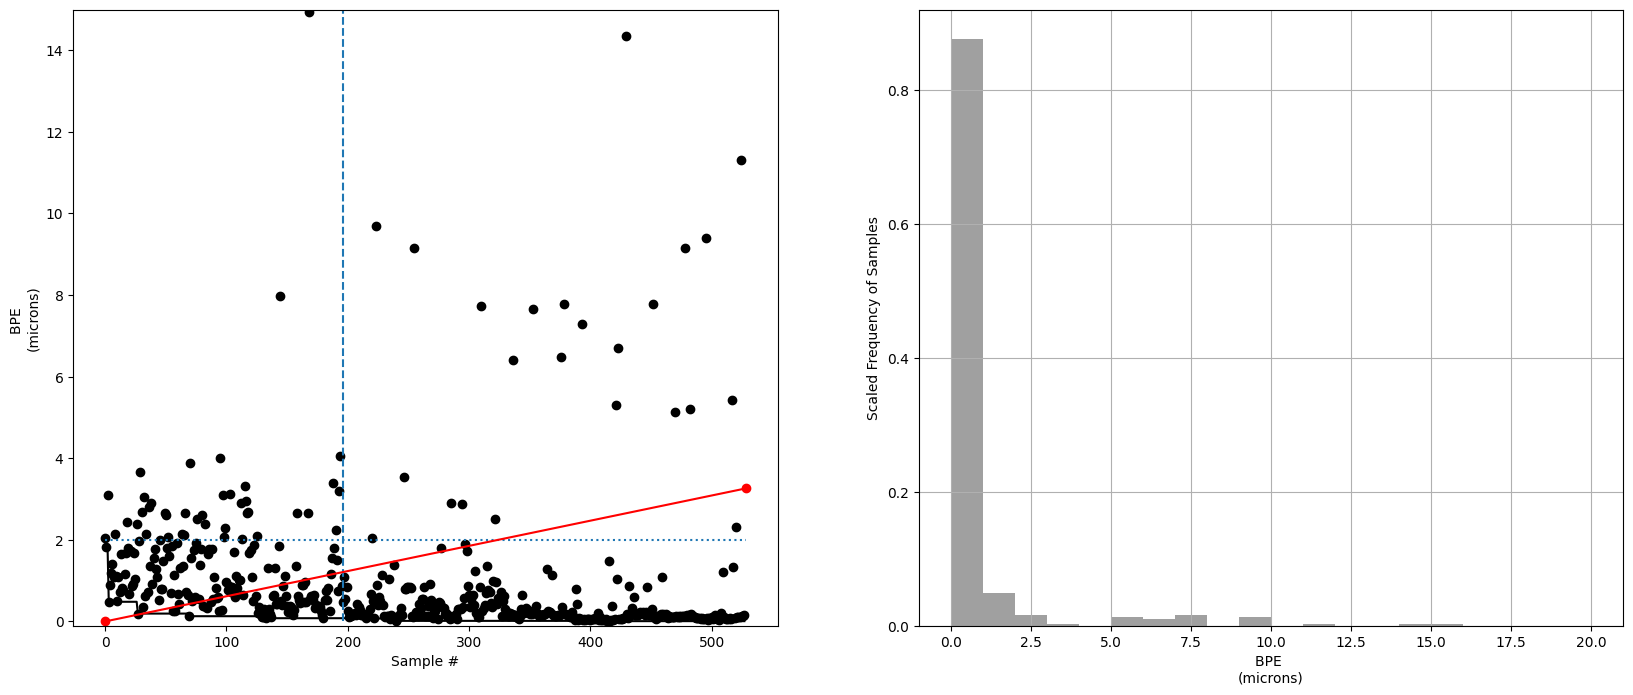

In [25]:
y1 = X.data["f"]
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(1,2,1)
y1_maxs = np.minimum.accumulate(y1)
ax1.plot(y1, 'ok')
ax1.plot(y1_maxs, 'k')
#plt.hlines(1, 0, len(y1_maxs), linestyles="dotted")
ax1.vlines(196, 0, 20, linestyles="dashed")
ax1.hlines(2, 0, len(y1), linestyles="dotted")
ax1.set_ylabel("BPE \n(microns)")
ax1.set_xlabel("Sample #")
ax1.set_ylim(-0.1, 15)


a=[0, len(y1)]
b=[0, 3.26]
for i in range(0, len(a), 2):
    ax1.plot(a[i:i+2], b[i:i+2], 'ro-')

ax2 = fig.add_subplot(1,2,2)
ax2.hist(y1[196:], density=True, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], facecolor='gray', alpha=0.75)
ax2.set_ylabel("Scaled Frequency of Samples")
ax2.set_xlabel("BPE \n(microns)")
ax2.grid()
#plt.savefig(f'AnisotropicDriftCorrection_TDBO.png', dpi=200)
plt.show()

In [ ]:
X.data.to_csv('history.csv', index=False)